# Cluster, Label, PCA, then visualize
8JAN2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [28]:
import pandas as pd, numpy as np, pickle, time, re

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from prettytable import PrettyTable
from prettytable import MSWORD_FRIENDLY, FRAME, ALL
from pprint import pprint

from scipy.spatial.distance import cosine, euclidean
from tqdm import tqdm

In [2]:
### load df with metadata

load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = '7800_tweets_known_domains_with_metadata.pkl'

with open(load_path + load_name, 'rb') as f:
    metadata_df = pickle.load(f)

    pd.set_option('display.max_columns', None)
metadata_df.head(3)


,created_at,id_str,entities,user,retweet_count,favorite_count,retweeted_status,Hash words,link,urls,first_url,url_total_retweets,url_total_favorites,article_text,article_text_preprocessed,domain,news,science,govt,dubious,not_any,group,month,week_num,no_www,fake_news,conspiracy,lean_left,lean_center,lean_right,lean_not_known,bias
0,2020-02-29 23:17:56+00:00,1.233894e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1172275165524385798, 'id_str': '1172275...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338942013953...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,1414.0,111.0,Thanks for contacting us. We've received your...,yaron steinbuch february updated february amid...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
1,2020-02-29 23:39:43+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 465592070, 'id_str': '465592070', 'name...",0.0,0.0,NaN,No hashtags,https://twitter.com/user/status/12338996799240...,[https://nypost.com/2020/02/28/israeli-scienti...,https://nypost.com/2020/02/28/israeli-scientis...,310.0,1055.0,"\nNews\n By Yaron Steinbuch \n\tFebruary 28, ...",yaron steinbuch february amid fears looming sc...,nypost.com,0,0,0,1,0,0,2020-02,9,nypost.com,0,0,0,0,1,0,5
2,2020-02-29 23:40:00+00:00,1.233900e+18,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 23081056, 'id_str': '23081056', 'name':...",328.0,0.0,{'created_at': 'Thu Feb 27 23:27:42 +0000 2020...,No hashtags,https://twitter.com/user/status/12338997538151...,[https://time.com/5790545/first-covid-19-vacci...,https://time.com/5790545/first-covid-19-vaccine/,73061.0,2115.0,"Moderna Therapeutics, a biotech company based...",moderna therapeutics biotech company based cam...,time.com,1,0,0,0,0,2,2020-02,9,time.com,0,0,1,0,0,0,3


<br><br><br>
### Make TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_df=.8)
X = vectorizer.fit_transform(metadata_df['article_text_preprocessed'])
print('{} articles. Vocabulary: {} words'.format(X.shape[0], X.shape[1]))

### save the vectorizer
src_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_vectorizer_after_fit_transform.pkl'
with open(src_path + tfidf_save_name, 'wb') as f:
    pickle.dump(vectorizer, f)


# keep ID labels with tfidf features
tfidf_feat = pd.DataFrame(data=X.toarray())
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
tfidf_with_id_str = pd.concat([id_strings, tfidf_feat], axis=1, ignore_index=True)
tfidf_with_id_str.rename(columns={0: "id_str"}, inplace=True)
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
tfidf_save_name = 'tfidf_7800_articles_df.pkl'

with open(save_path + tfidf_save_name, 'wb') as f:
    pickle.dump(tfidf_with_id_str, f)


<br><br>
### make PCA

In [ ]:
from sklearn.decomposition import PCA
trans = PCA(n_components=2)
pca_feat = trans.fit_transform(tfidf_feat)

# pca_features_df = pd.DataFrame(data = pca_feat, columns = ['principal component 1', 'principal component 2'])

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_feat_ndarray.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_feat, f)
    
pca_feat_df = pd.DataFrame(data=pca_feat)
id_strings = pd.DataFrame(data=metadata_df['id_str'], columns = ['id_str'])
id_strings.reset_index(inplace=True, drop=True)
pca_with_id_str = pd.concat([id_strings, pca_feat_df], axis=1, ignore_index=True)
pca_with_id_str.rename(columns={0: "id_str"}, inplace=True)

save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
save_name = 'pca_2d_7800_articles_df.pkl'

with open(save_path + save_name, 'wb') as f:
    pickle.dump(pca_with_id_str, f)


<br><br><br>
## Load PCA and TFIDF DataFrames

In [3]:
### load tfidf df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'tfidf_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    tfidf_df = pickle.load(f)
tfidf_df.head(3)


### load pca df
load_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
load_name = 'pca_2d_7800_articles_df.pkl'

with open(load_path + load_name, 'rb') as f:
    pca_df = pickle.load(f)


pca_feat = pca_df.iloc[:, 1:]
pca_df.head()

### same number of articles for each
assert(pca_df.shape[0] == tfidf_df.shape[0] == metadata_df.shape[0])

<br><br><br>
## KMeans Clustering, apply labels

In [ ]:
tfidf_feat = tfidf_df.iloc[:, 1:]

print('KMeans of TFIDF Features')
print('7800 articles, all domains, 20k vocab...\n')

preds_dict = {}
silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(tfidf_feat)
    preds = kmeans.predict(tfidf_feat)
    silhouette = silhouette_score(tfidf_feat, preds)
    
    preds_dict['k_means_' + str(n_cluster)] = preds
    silhouettes_dict['k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

### save
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'

preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
# KMeans
with open(save_path + preds_dict_save_name, 'wb') as f:
    pickle.dump(preds_dict, f)
    
with open(save_path + silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(silhouettes_dict, f)


<br><br><br>
## KMedoids

In [ ]:
! pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

print('KMedoids of TFIDF Features with Cosine Distance')
print('7800 articles, all domains, 20k vocab\n')

medoids_preds_dict = {}
medoids_silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:
    kmedoids = KMedoids(n_clusters=n_cluster, metric='cosine', 
                    init='heuristic', max_iter=300, random_state=42).fit(tfidf_feat)
    preds = kmedoids.labels_
    silhouette = silhouette_score(tfidf_feat, preds)
    
    medoids_preds_dict['k_medoids_' + str(n_cluster)] = preds
    medoids_silhouettes_dict['k_medoids_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster, silhouette))

### save
medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'

with open(save_path + medoids_preds_dict_save_name, 'wb') as f:
    pickle.dump(medoids_preds_dict, f)
    
with open(save_path + medoids_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(medoids_silhouettes_dict, f)


<b><br><br>
### KMeans on PCA Features

In [ ]:
### PCA features
print('KMeans of PCA Features')
print('7800 articles, all domains, 20k vocab...\n')

pca_kmeans_preds_dict = {}
pca_kmeans_silhouettes_dict = {}

n_clusters = range(2,12)
for n_cluster in n_clusters:    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(pca_feat)
    preds = kmeans.predict(pca_feat)
    silhouette = silhouette_score(pca_feat, preds)
    
    pca_kmeans_preds_dict['pca_k_means_' + str(n_cluster)] = preds
    pca_kmeans_silhouettes_dict['pca_k_means_' + str(n_cluster)] = silhouette
    
    print("Silhouette score for {} clusters: {}".format(n_cluster,silhouette))

### save
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

with open(save_path + pca_kmeans_preds_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_preds_dict, f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'wb') as f:
    pickle.dump(pca_kmeans_silhouettes_dict, f)

<br><br><br>
# Open preds and silhouettes dictionaries
<br><br><br>


In [4]:
save_path = '/Volumes/seagate_external_drive/anti_vax_embeddings/src/JAN2021/'

preds_dict_save_name = 'kmeans_preds_dict.pkl'
silhouettes_dict_save_name = 'kmeans_silhouettes_dict.pkl'
medoids_preds_dict_save_name = 'kmedoids_preds_dict.pkl'
medoids_silhouettes_dict_save_name = 'kmedoids_silhouettes_dict.pkl'
pca_kmeans_preds_dict_save_name = 'pca_kmeans_preds_dict.pkl'
pca_kmeans_silhouettes_dict_save_name = 'pca_kmeans_silhouettes_dict.pkl'

# KMeans
with open(save_path + preds_dict_save_name, 'rb') as f:
    preds_dict = pickle.load(f)
    
with open(save_path + silhouettes_dict_save_name, 'rb') as f:
    silhouettes_dict = pickle.load(f)
    
# # KMedoids
with open(save_path + medoids_preds_dict_save_name, 'rb') as f:
    medoids_preds_dict = pickle.load(f)
    
with open(save_path + medoids_silhouettes_dict_save_name, 'rb') as f:
    medoids_silhouettes_dict = pickle.load(f)
    
# PCA KMeans
with open(save_path + pca_kmeans_preds_dict_save_name, 'rb') as f:
    pca_kmeans_preds_dict = pickle.load(f)
    
with open(save_path + pca_kmeans_silhouettes_dict_save_name, 'rb') as f:
    pca_kmeans_silhouettes_dict = pickle.load(f)

<br><br><br>
### Plot Silhouette Scores

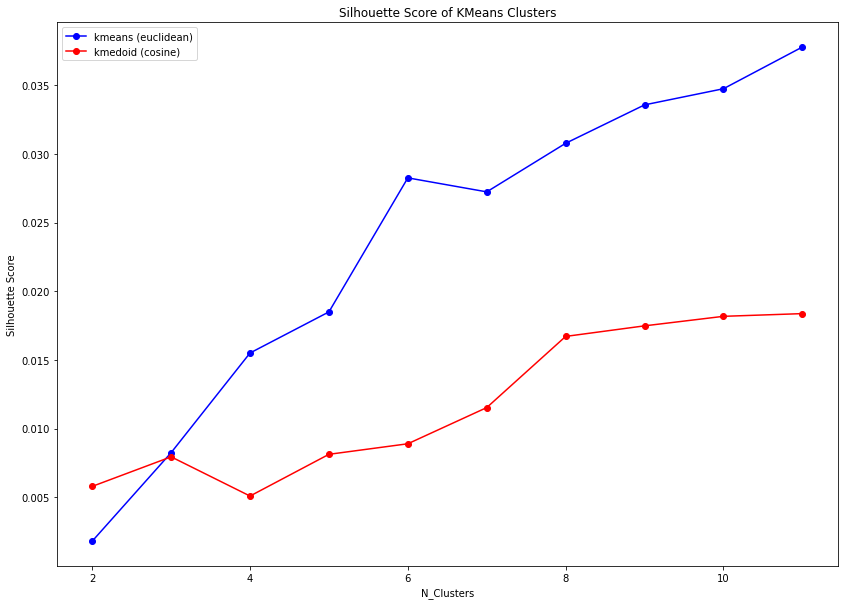

In [6]:
n_clusters = range(2,12)
plt.figure(figsize=(14,10))
plt.plot(n_clusters, silhouettes_dict.values(), 'bo-', label='kmeans (euclidean)')
plt.plot(n_clusters, medoids_silhouettes_dict.values(), 'ro-', label='kmedoid (cosine)')

plt.title('Silhouette Score of KMeans Clusters')
plt.ylabel('Silhouette Score')
plt.xlabel('N_Clusters')
plt.legend()
plt.show()

Elbows at n_clusters = 6 (KMeans) and n_clusters = 8 (KMedoids)
<br><br><br><br><br><br><br><br><br>

### Plot PCA scatter plot with clustering labels for colors

In [38]:
color_dict_labels = {'0': 'xkcd:blue', '1': 'xkcd:light green', '2': 'xkcd:orange',
                     '3': 'xkcd:red', '4': 'xkcd:pink', '5': 'xkcd:yellow',
                     '6': 'xkcd:dark green', '7': 'xkcd:cyan', '8': 'xkcd:navy blue',
                     '9': 'xkcd:maroon', '10': 'xkcd:magenta', '11': 'xkcd:violet',
                     '12': 'xkcd:green', '13': 'xkcd:olive',
                    }
color_dict_domains = {'0': 'red', '1': 'cyan', '2':'cyan', '3': 'black', '4':'green'}

color_dict_bias = {'0': 'black', '1': 'purple', '2':'green', '3': 'cyan', '4':'orange', '5': 'red'}

domain_map = {'0': 'dubious',
              '1': 'govt',
              '2': 'news',
              '3': 'unknown domain (not included)',
              '4': 'science'
             }

bias_map = {'0': 'conspiracy',
            '1': 'fake_news',
            '2': 'lean_center',
            '3': 'lean_left',
            '4': 'lean_not_known',
            '5': 'lean_right',
            }

In [39]:


def plot_pca_clustering(num_clusters=6, cluster_type='kmeans'):
    
    print('Num clusters: {}'.format(num_clusters))
    print('cluster type: ' + cluster_type)
    
    
    plt.figure(figsize=(14,10))
    if cluster_type == 'kmeans':
        key = 'k_means_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    elif cluster_type == 'kmedoids':
        key = 'k_medoids_' + str(num_clusters)
        plt.scatter(pca_feat[1], pca_feat[2], 
                        c = [color_dict_labels[str(i)] for i in medoids_preds_dict[key]],
                        alpha=.05,
                        s = 100
                       )
    plt.title('2-Dim PCA Scatter\n'+cluster_type+': n_clusters = {}'.format(num_clusters))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

In [ ]:
plot_pca_clustering(6, 'kmeans')
print('\ncolors')
for i in range(6):
    print(f'group {i} color: {color_dict_labels[str(i)]}')

print('\nArticles per topic group')
unique, counts = np.unique(preds_dict['k_means_6'], return_counts=True)
print(np.asarray((unique, counts)).T)


N_Clusters = 5 shows three outlying groups (light green, pink, orange) but 7000 of the 7800 articles are topic 3 (red) or topic 5 (yellow). 
<br><br><br><br><br>

In [ ]:
plot_pca_clustering(8, 'kmedoids')
print('\ncolors')
for i in range(9):
    print(f'group {i} color: {color_dict_labels[str(i)]}')
    
print('\nArticles per topic group')
unique, counts = np.unique(medoids_preds_dict['k_medoids_8'], return_counts=True)
print(np.asarray((unique, counts)).T)


KMedoids n_clusters = 8
- Harder to see in 2-d... will need to see how top words shape out
- More balance among classes. We may see better sub-narratives within the overarching coronavirus storyline
- Perhaps we can show only a few layers at a time to see how the main cluster breaks down

# Next Step

In [8]:
metadata_cols_to_keep = ['id_str', 'url_total_retweets', 'url_total_favorites', 'group', 'bias', 'month', 'week_num' ]
metadata_small = metadata_df.copy(deep=True)
metadata_small = metadata_small[metadata_cols_to_keep]
pca_ready = pd.merge(pca_df, metadata_small, on=["id_str"])
tfidf_ready = pd.merge(tfidf_df, metadata_small, on=["id_str"])

pca_ready['k_means_6'] = preds_dict['k_means_6']
tfidf_ready['k_means_6'] = preds_dict['k_means_6']

pca_ready['k_medoids_8'] = medoids_preds_dict['k_medoids_8']
tfidf_ready['k_medoids_8'] = medoids_preds_dict['k_medoids_8']

In [9]:
def top_words(col_name, label, input_df=tfidf_ready, n_words=25):
    df = input_df.copy()
    top_words_list = []
    num_tfidf_features = range(1, tfidf_df.shape[1])    
    temp_df = df[df[col_name] == label]
    means = []

    for feat in num_tfidf_features:
        means.append(temp_df[feat].mean())
    means = np.array(means)

    feature_array = np.array(vectorizer.get_feature_names())
    sorted_word_idxs = np.argsort(means).flatten()[::-1]
    top_words = list(feature_array[sorted_word_idxs][:n_words])
    return top_words

In [ ]:
n_words = 250
topics = 6
method = 'k_means_'

print(f'Top {n_words} words in each of the {topics} topic groups')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}')
    print(top_words(method+str(topics), label=i, n_words=n_words))
    

In [ ]:
k_means_table = PrettyTable()
k_means_table.field_names = ['Label', 'Color', 'Topic', 'N_Articles', 'Selected Top Words']
k_means_table.add_row(['0', 'Blue', 'Fa...', '49', 'farge, fared, farmed, fargo, fated, fasting,\n'])
k_means_table.add_row(['1', 'Light Green', 'Vaccine Dev', '139',  'Astrazenica, Moderna, Trials, Breakthrough, Potential, Testing, Mass, Vial\n'])
k_means_table.add_row(['2', 'Orange', 'Politics', '337', 'Biden, President, Trump, Brazil, Schumer, Republicans, Protesters, McConnell, Chechen, Protested\n'])
k_means_table.add_row(['3', 'Red', 'Response', '5142', 'New, Cases, Trump, China, Flu, World, Public, Disease, Government, Information, Outbreak, Wuhan, Gates\n'])
k_means_table.add_row(['4', 'Pink', 'Finance',  '157', 'Vanguard, Stock, Company, Market, Buy, Investors, Shares, Growth\n'])
k_means_table.add_row(['5', 'Yellow', 'Drug Trials', '2000', 'Trials, Trial, Doses, Clinical, Moderna, Oxford, Astrazenica, Antibodies, Testing, Research, Animals, Promising, Drugmaker\n'])

k_means_table._max_width = {'Label': 5, 'Selected Top Words': 40}

k_means_table.align = 'l'

print('KMeans / 6 Topics\n')
print(k_means_table)


In [ ]:
n_words = 250
topics = 8
method = 'k_medoids_'

print(f'Top {n_words} words in each of the {topics} topic groups')
for i in range(topics):
    print('\n' + '-'*80)
    print(f'\nTopic Group #{i}')
    print(top_words(method+str(topics), label=i, n_words=n_words))
    

In [ ]:
k_medoids_table = PrettyTable()
k_medoids_table.field_names = ['Label', 'Color', 'Topic', 'N_Articles', 'Selected Top Words']
k_medoids_table.add_row(['0', 'Blue', 'Onset', '1667', 'China, Cases, Outbreak, New, World, Countries, Disease, Global, December, New, Italy, Outbreak, January, February\n'])
k_medoids_table.add_row(['1', 'Light Green','Conspiracy', '1148',  'Wuhan, Gates, Natural, Children, Bats, Conspiracy, Autism, Lab, Truth, Vitamin, Chinese, Theory, Polio, \n'])
k_medoids_table.add_row(['2', 'Orange', 'Politics', '590', 'Biden, President, Trump, Brazil, Schumer, Republicans, Anzorov, McConnell, Chechen, Protested, Forgiving\n'])
k_medoids_table.add_row(['3', 'Red', 'Response', '732', 'Deaths, Number, Lockdown, Public, Infections, Day, Fauci, June, Distancing, Reopening, Quarantine, Surge, Stay, Boris, Open, Rise, Surge, Evidence, Community\n'])
k_medoids_table.add_row(['4', 'Pink', 'Finance',  '337', 'Vanguard, Stock, Market, Buy, Investors, Shares, Quarter, Fund, Buys, Index, Bullish, Bridgewater\n'])
k_medoids_table.add_row(['5', 'Yellow', 'Anti-Vax.', '309', 'Pandemrix, Narcolepsy, Hepatitis, HPV, Influenza, Autism, Surveillance, Pregnant, Swine, Guillain, Meningococcal, Unvaccinated\n'])
k_medoids_table.add_row(['6', 'Dark Green', 'Lockdowns', '1422', 'Trump, Government, World, President, Lockdown, Mercola, Djokovic, Children, British, States, Time, Work, Restrictions, Mask, Schools, Privacy, Risk, Rights, Workers, Capacity\n'])
k_medoids_table.add_row(['7', 'Cyan', 'Vaccine Trials', '1619', 'Trials, Immune, Moderna, Doses, Oxford, Astrazenica, MRNA, Production, Protein, Volunteers, Stage, Efficacy, RNA, Science, Biotech\n'])


k_medoids_table._max_width = {'Label': 5, 'Selected Top Words': 40}

k_medoids_table.align = 'l'
# k_medoids_table.hrules = FRAME

print('K Medoids / 8 Topics\n')
print(k_medoids_table)

In [ ]:
pca_ready.head()

In [10]:
def plot_clusters(title: str, unit = "-1", col = 'k_medoids_8', color_by = 'k_medoids_8', input_df=pca_ready, label1=-1, label2=-1, label3 = -1, label4=-1, label_exclude=-1, alpha=0.05):
    df = input_df.copy()
    print('col: ' + col )
    print('time unit: ' + unit)
    print('color_by: ' + color_by)
    
    ### color by
    if color_by == 'k_medoids_8':
        color_dict = color_dict_labels
        print('Coloring by Topic Labels')
    elif color_by == 'group':
        color_dict = color_dict_domains
        print('Coloring by Domain Group')
    elif color_by == 'bias':
        color_dict = color_dict_bias
        print('Coloring by Political Bias')

    ### exclude
    if label_exclude !=-1:
        df = df[df[col] != label_exclude]
    ### select up to 4 labels (or all labels)
    if (label1 != -1) and (label2 != -1) and (label3 != -1) and (label4 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3) | (df[col] == label4)]    
    elif (label1 != -1) and (label2 != -1) and (label3 != -1):
        df = df[(df[col] == label1) | (df[col] == label2) | (df[col] == label3)]
    elif (label1 != -1) and (label2 != -1):
        df = df[(df[col] == label1) | (df[col] == label2)]
    elif label1 != -1:
        df = df[df[col] == label1]
        
    
    ### time
    if unit != '-1':
        if unit == 'month':
            time = pca_ready['month'].value_counts().sort_index().index
        elif unit == 'week_num':
            time = pca_ready['week_num'].value_counts().sort_index().index


        for t in time:
            plt.figure()
            plt.figure(figsize=(10,8))
            plt.xlim(-.3, .8)
            plt.ylim(-.3, .95)

            df_time = df[df[unit] == t]
    #         print(df_month.shape)

            plt.title(title + '\n' + unit + ': ' + str(t))
            plt.scatter(df_time[1], df_time[2], 
                    c = [color_dict[str(i)] for i in df_time[color_by]],
                    alpha=alpha,
                    s = 100
                   )
    elif unit == '-1':
        plt.figure(figsize=(14,10))
        plt.title(title)
        plt.scatter(df[1], df[2], 
                    c = [color_dict[str(i)] for i in df[color_by]],
                    alpha=alpha,
                    s = 100
                   )
  
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.xlim(-.3,.8)
    plt.ylim(-.3,.95)
    plt.show()

col: k_medoids_8
time unit: -1
color_by: k_medoids_8
Coloring by Topic Labels


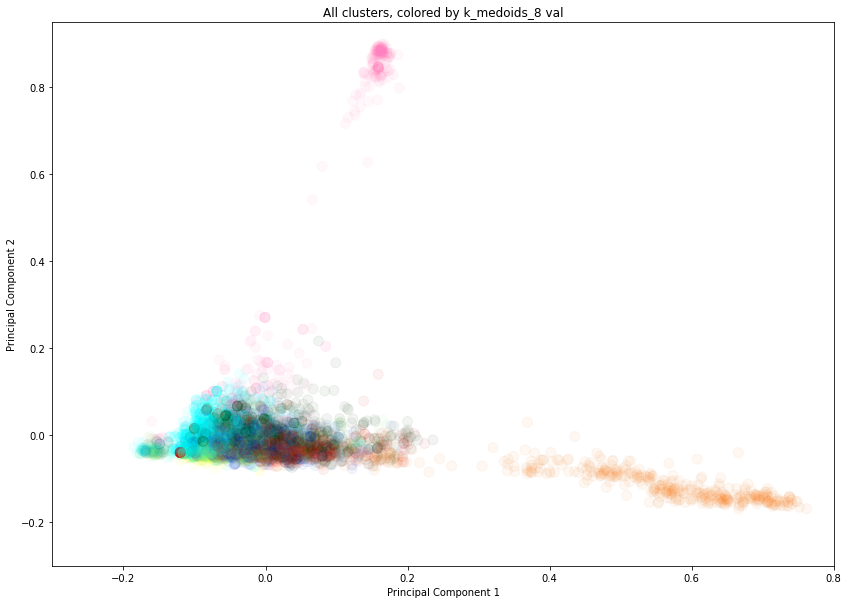

In [11]:
plot_clusters(title='All clusters, colored by k_medoids_8 val')

In [ ]:
### Many topics overlap in 2-d plot
print('Each Topic Group')
for i in range(8):
    plot_clusters(title='K_Medoids_Topic' + str(i), label1=i)

In [ ]:
# for topic in range(8):
#     print(f'Topic {topic} over time')
#     plot_clusters(title='K_Medoids_Topic' + str(topic), label1=topic, unit="week_num")

# Heatmap

In [12]:
temp = pca_ready.copy(deep=True)
months = pca_ready['month'].value_counts().sort_index().index
weeks = pca_ready['week_num'].value_counts().sort_index().index

In [13]:
temp_df = pca_ready.copy(deep=True)
def article_counts_matrix(time_name:str, normalize_on:str, df = temp_df, col='k_medoids_8'):
    if time_name == 'month':
        times = months
    elif time_name == 'week_num':
        times = weeks


    all_topics = []
    for topic in range(8):
        this_topic = []
    #     print(f'\ntopic: {topic}')
        topic_sum = pca_ready[df[col] == topic].shape[0]
    #     print(f'topic sum: {topic_sum}')
        for time_unit in times:
            this_topic.append(df[(df[col] == topic) & (df[time_name] == time_unit)].shape[0])
    #     print(this_topic)
        all_topics.append(this_topic)
    #     print(f'all topics: {all_topics}')

    raw_counts = np.vstack(np.asarray(topic_list) for topic_list in all_topics)
    normalized = raw_counts.astype('float32')
    
    if normalize_on == 'topic':
#         for i in range(normalized.shape[0]):
#             temp = normalized[i].copy()
#             row_sum = float(temp.sum())
#             temp = temp/row_sum
#             normalized[i] = temp
        return normalized/normalized.sum(axis=1,keepdims=1)
    elif normalize_on == 'time':
        return normalized/normalized.sum(axis=0,keepdims=1)



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



Topic 5 (anti-vax) decreases over time. Topics 0, 1 start strong, dip, then get strong again. 2, 3, 4, start slow get much stronger


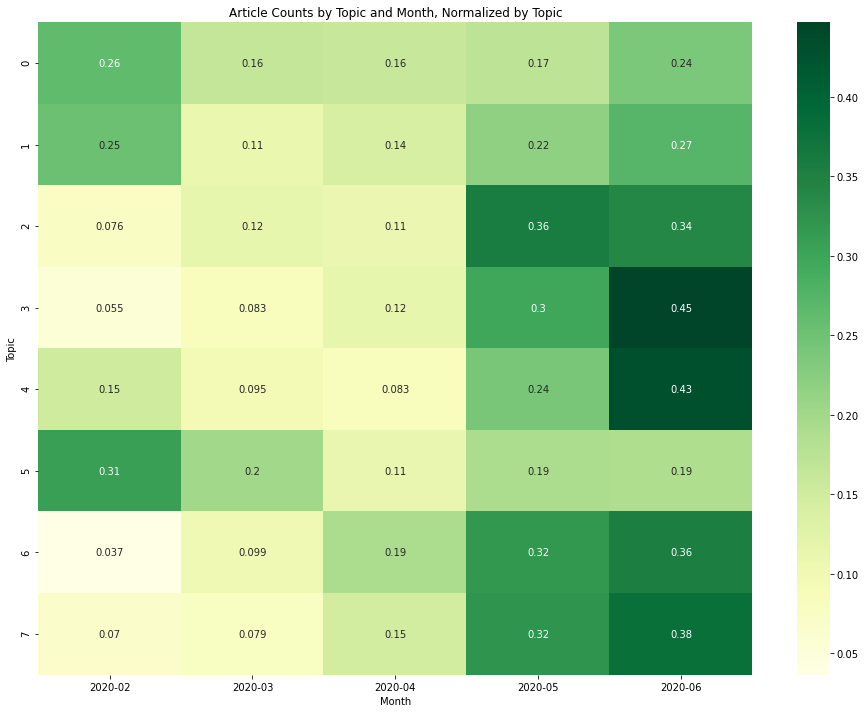

In [14]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_topic_normalized = article_counts_matrix(time_name='month', normalize_on='topic')
sns.heatmap(counts_by_month_topic_normalized, annot=True, cmap='YlGn', xticklabels=months, ax=ax)
ax.set_title('Article Counts by Topic and Month, Normalized by Topic')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')

print('\nTopic 5 (anti-vax) decreases over time. Topics 0, 1 start strong, dip, then get strong again. 2, 3, 4, start slow get much stronger')



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



Topic 0 and 1 dominate Feb-Mar, Topics 6 and 7 stronger April-June


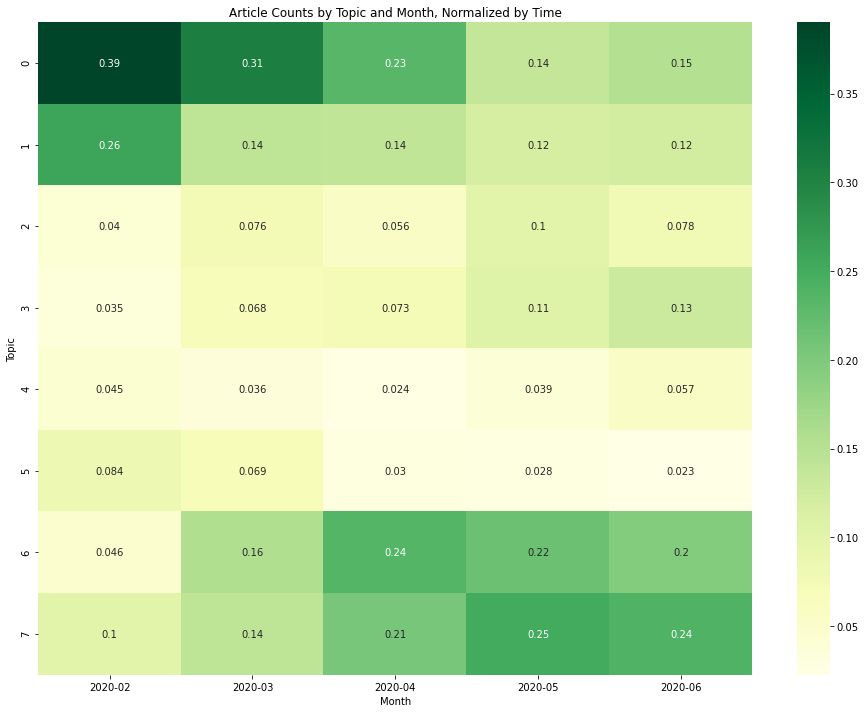

In [15]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_month_time_normalized = article_counts_matrix(time_name='month', normalize_on='time')
sns.heatmap(counts_by_month_time_normalized, annot=True, cmap='YlGn', xticklabels=months, ax=ax)
ax.set_title('Article Counts by Topic and Month, Normalized by Time')
ax.set_xlabel('Month')
ax.set_ylabel('Topic')

print('\nTopic 0 and 1 dominate Feb-Mar, Topics 6 and 7 stronger April-June')


/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

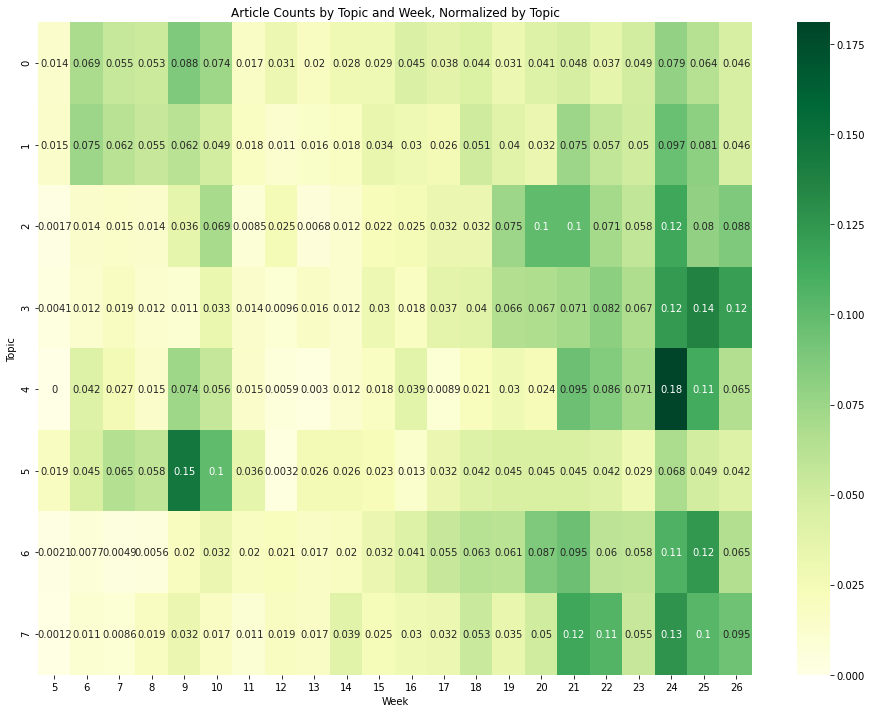

In [16]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_topic_normalized = article_counts_matrix(time_name='week_num', normalize_on='topic')
sns.heatmap(counts_by_week_topic_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Article Counts by Topic and Week, Normalized by Topic')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')



/Volumes/seagate_external_drive/anti_vax_embeddings/env_anti_vaccine/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Text(123.0, 0.5, 'Topic')

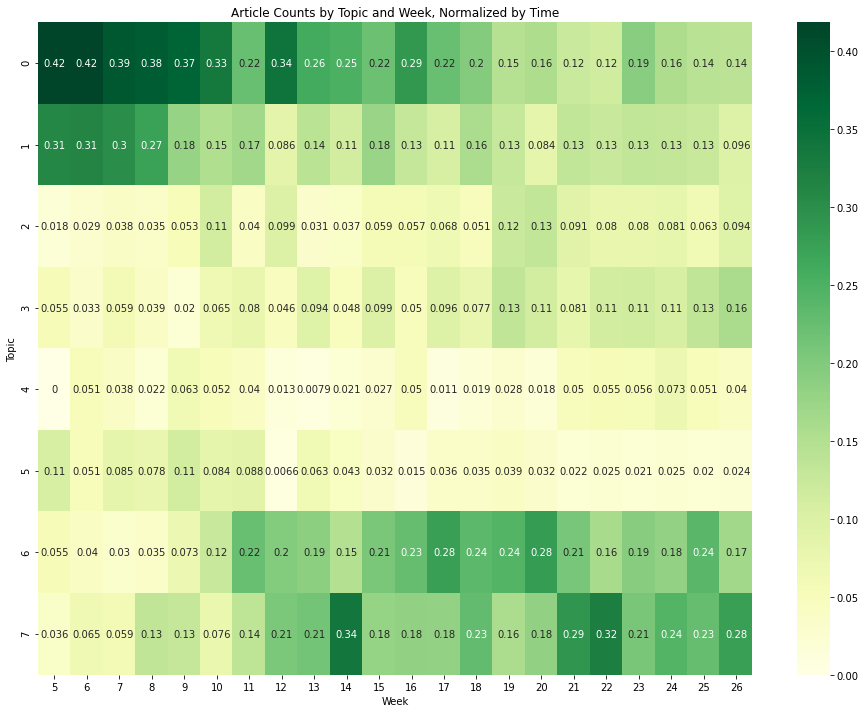

In [17]:
plt.figure(figsize=(16, 12))
ax = plt.axes()
counts_by_week_time_normalized = article_counts_matrix(time_name='week_num', normalize_on='time')
sns.heatmap(counts_by_week_time_normalized, annot=True, cmap='YlGn', xticklabels=weeks, ax=ax)
ax.set_title('Article Counts by Topic and Week, Normalized by Time')
ax.set_xlabel('Week')
ax.set_ylabel('Topic')

In [ ]:
# maybe do same thing with bias or domain?

# ================================================
# ================================================
# Average Linkage Between Domains and Topics

In [ ]:
### too hard to see bias/domain in topics using 2-d plot
# for i in range(8):
#     plot_clusters(title='topic coloring topic {}'.format(i), color_by = 'k_medoids_8', label1=i)
#     plot_clusters(title='bias coloring topic {}'.format(i), color_by = 'bias', label1=i)
#     plot_clusters(title='domain coloring topic {}'.format(i), color_by = 'group', label1=i)

In [34]:
def select_points_tfidf(col, label):
    temp = tfidf_ready[tfidf_ready[col] == label]
    temp = temp.iloc[:, 1:20213]
    return temp.to_numpy()

def select_points_pca(col, label):
    temp = pca_ready[pca_ready[col] == label]
    temp = temp.iloc[:, 1:3]
    return temp.to_numpy()

def average_distance(matrix1, matrix2, metric='euclidean'):    
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]

    sum_dists = 0
    
    for i in range(n1):
        for j in range(n2):
            if metric=='cosine': # better for high dimensions
                sum_dists += cosine(matrix1[i], matrix2[j])
            elif metric == 'euclidean':
                sum_dists += euclidean(matrix1[i], matrix2[j])
    avg_dists = sum_dists/(n1*n2)
    return avg_dists

def compute_average_linkage(col1, label1, col2, label2, title:str, points='pca', metric='euclidean'):
    if points == 'pca':
        points1 =  select_points_pca(col1, label1)
        points2 = select_points_pca(col2, label2)
    ### doing it with TFIDF features would take 45+ minutes per comparison
    elif points == 'tfidf':
        points1 = select_points_tfidf(col1, label1)
        points2 = select_points_tfidf(col2, label2)
    avg_dist = average_distance(points1, points2, metric=metric)
    print(title + ': ' + str(avg_dist))
    return avg_dist


### doing with TFIDF features would be 45+ min per combo
# dubious_points_tfidf = select_points_tfidf('group', 0)
# science_points_tfidf = select_points_tfidf('group', 4)

# n1 = dubious_points_tfidf.shape[0]
# n2 = science_points_tfidf.shape[0]

# sum_dists = 0
# for i in tqdm(range(n1)):
#     for j in range(n2):
#         sum_dists += cosine(dubious_points_tfidf[i], science_points_tfidf[j])
# avg_dists = sum_dists/(n1*n2)
# print(avg_dists)

In [32]:
print('Average Linkage')
print('----- Dubious vs Topic Groups ----')
for i in range(8):
    compute_average_linkage('group', 0, 'k_medoids_8', i, title='Dubious vs Topic Group {}'.format(i))

  0%|          | 2/1836 [00:00<01:54, 15.97it/s]

Average Linkage
----- Dubious vs Topic Groups ----


  0%|          | 3/1836 [00:00<01:04, 28.45it/s]

Dubious vs Topic Group 0: 0.060961736105332905


  0%|          | 6/1836 [00:00<00:32, 55.99it/s]

Dubious vs Topic Group 1: 0.06420823903739198


  0%|          | 4/1836 [00:00<00:46, 39.24it/s]

Dubious vs Topic Group 2: 0.3893580331845047


  1%|          | 19/1836 [00:00<00:19, 92.26it/s]

Dubious vs Topic Group 3: 0.07553658046953907


  1%|          | 22/1836 [00:00<00:18, 100.72it/s]

Dubious vs Topic Group 4: 0.48021370290938775


  0%|          | 3/1836 [00:00<01:03, 28.82it/s]

Dubious vs Topic Group 5: 0.06308610665030479


  0%|          | 2/1836 [00:00<01:48, 16.92it/s]

Dubious vs Topic Group 6: 0.07427460746118882


100%|██████████| 1836/1836 [01:22<00:00, 22.15it/s]

Dubious vs Topic Group 7: 0.07611788638910164


In [35]:
print('----- Domain vs Topic Groups ----')
dubious_vs_topic = {}
govt_vs_topic = {}
news_vs_topic = {}
science_vs_topic = {}

for i in tqdm(range(8)):
    dubious_vs_topic[str(i)] = (compute_average_linkage('group', 0, 'k_medoids_8', i, title='Dubious vs Topic {}'.format(i)))
    govt_vs_topic[str(i)] = (compute_average_linkage('group', 1, 'k_medoids_8', i, title='Govt vs Topic {}'.format(i)))
    news_vs_topic[str(i)] = (compute_average_linkage('group', 2, 'k_medoids_8', i, title='News vs Topic {}'.format(i)))
    science_vs_topic[str(i)] = (compute_average_linkage('group', 4, 'k_medoids_8', i, title='Science vs Topic {}'.format(i)))

zero = np.asarray(list(dubious_vs_topic.values()))
one = np.asarray(list(govt_vs_topic.values()))
two = np.asarray(list(news_vs_topic.values()))
four = np.asarray(list(science_vs_topic.values()))

domain_vs_topic = np.vstack((zero, one, two, four))
print(type(domain_vs_topic))

plt.figure(figsize=(16, 12))
ax = plt.axes()
sns.heatmap(domain_vs_topic, annot=True, cmap='OrRd', xticklabels=range(0,8), yticklabels=[0,1,2,4], ax=ax)
ax.set_title('Distance between Domain and Topic')
ax.set_xlabel('Topic')
ax.set_ylabel('Domain')

  0%|          | 0/8 [00:00<?, ?it/s]

----- Domain vs Topic Groups ----
Dubious vs Topic 0: 0.060961736105332905
Govt vs Topic 0: 0.06314043429428653
News vs Topic 0: 0.1519288441471926


 12%|█▎        | 1/8 [04:23<30:42, 263.19s/it]

Science vs Topic 0: 0.06801795344329796
Dubious vs Topic 1: 0.06420823903739198
Govt vs Topic 1: 0.06192039706218947
News vs Topic 1: 0.15765576513826568


 25%|██▌       | 2/8 [07:26<23:55, 239.21s/it]

Science vs Topic 1: 0.062335341612145496
Dubious vs Topic 2: 0.3893580331845047
Govt vs Topic 2: 0.4074812969361111
News vs Topic 2: 0.4057228720510431


 38%|███▊      | 3/8 [09:00<16:18, 195.68s/it]

Science vs Topic 2: 0.4236783218093125
Dubious vs Topic 3: 0.07553658046953907
Govt vs Topic 3: 0.08245922738423563
News vs Topic 3: 0.15969523312090553


 50%|█████     | 4/8 [10:55<11:25, 171.40s/it]

Science vs Topic 3: 0.08928812989432286
Dubious vs Topic 4: 0.48021370290938775
Govt vs Topic 4: 0.4822440289431169
News vs Topic 4: 0.5060832410063181


 62%|██████▎   | 5/8 [11:47<06:46, 135.60s/it]

Science vs Topic 4: 0.4927009487504194
Dubious vs Topic 5: 0.06308610665030479
Govt vs Topic 5: 0.056208632768275486
News vs Topic 5: 0.16048652970219637


 75%|███████▌  | 6/8 [12:35<03:38, 109.30s/it]

Science vs Topic 5: 0.05062248736322976
Dubious vs Topic 6: 0.07427460746118882
Govt vs Topic 6: 0.08099687276525218
News vs Topic 6: 0.15705025606089876


 88%|████████▊ | 7/8 [16:15<02:22, 142.64s/it]

Science vs Topic 6: 0.09052898368054377
Dubious vs Topic 7: 0.07611788638910164
Govt vs Topic 7: 0.06516389123754612
News vs Topic 7: 0.16757204092094213


100%|██████████| 8/8 [46:01<00:00, 345.24s/it]

Science vs Topic 7: 0.061640317803150386


<class 'numpy.ndarray'>


Text(123.0, 0.5, 'Domain')

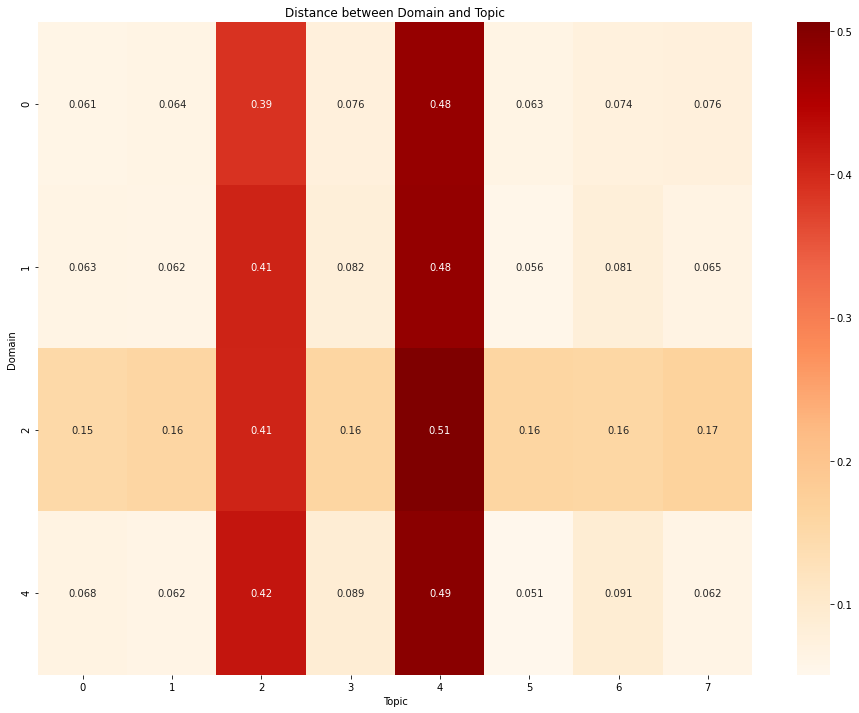